In [1]:
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import seaborn as sns
import torch
from torchsummary import summary
from torchvision import models
from torch import nn
from torch import optim
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.autograd import Variable
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
from tqdm import tqdm
import timm  # For loading Swin Transformer models
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
from sklearn.metrics import f1_score, accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import shutil
import warnings
warnings.filterwarnings("ignore")

code_dir = '/kaggle/working'
model_dir = '/kaggle/working'
output_dir = '/kaggle/working/output'

if not os.path.exists(code_dir):
    os.mkdir(code_dir)

if not os.path.exists(model_dir):
    os.mkdir(model_dir)

if not os.path.exists(output_dir):
    os.mkdir(output_dir)


In [2]:
# Set seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [3]:
# Configuration
class Config:
    data_dir = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake"  # Update this path
    batch_size = 32
    num_workers = 4
    image_size = 224  # Swin Transformer generally uses 224x224
    num_epochs = 10
    learning_rate = 1e-4
    weight_decay = 1e-4
    model_name = "swin_base_patch4_window7_224"  # Smaller version for faster training
    checkpoint_path = os.path.join(model_dir, "swin_dropNull.pth")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Learning rate scheduler settings
    scheduler_type = "cosine"  # Options: "cosine", "plateau", None
    min_lr = 1e-6  # Minimum learning rate for cosine scheduler
    patience = 3   # Patience for ReduceLROnPlateau
    cooldown = 1   # Cooldown period after reducing LR
    lr_factor = 0.1  # Factor by which to reduce LR

In [4]:
def train_data_transform(model_type, data_fraction, batch_size, shuffle=True, num_workers=4, pin_memory=True):
    if model_type == "swin":
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]

        transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])

    full_train_dataset = ImageFolder("/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train", transform=transform)
    num_train_data = int(len(full_train_dataset) * data_fraction)
    train_indices = random.sample(range(len(full_train_dataset)), num_train_data)
    train_dataset = torch.utils.data.Subset(full_train_dataset, train_indices)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=Config.num_workers, pin_memory=True)

    return train_dataloader


In [6]:
def val_data_transform(model_type, data_fraction, batch_size, shuffle=False, num_workers=4, pin_memory=True):
    # Common ImageNet normalization mean and std
   
    if model_type == 'swin':
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        # Manually define the transform for Swin using the same ImageNet normalization
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])
    
    else:
        raise ValueError(f"Unsupported model type: {model_type}")

    full_valid_dataset = ImageFolder("/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid", transform=transform)

    num_valid_data = int(len(full_valid_dataset) * data_fraction)
    random.seed(42)
    valid_indices = random.sample(range(len(full_valid_dataset)), num_valid_data)
    valid_dataset = torch.utils.data.Subset(full_valid_dataset, valid_indices)

    val_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    return val_dataloader

In [7]:
def test_data_transform(model_type, data_fraction, batch_size, shuffle=False, num_workers=4, pin_memory=True):
    # Common ImageNet normalization mean and std     
    if model_type == 'swin':
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]

        # Manually define the transform for Swin using the same ImageNet normalization
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])
    
    else:
        raise ValueError(f"Unsupported model type: {model_type}")
    
    full_test_dataset = ImageFolder("/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test", transform=transform)

    num_test_data = int(len(full_test_dataset) * data_fraction)
    random.seed(42)
    test_indices = random.sample(range(len(full_test_dataset)), num_test_data)

    test_dataset = torch.utils.data.Subset(full_test_dataset, test_indices)

    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return test_dataloader

# Orginal training process

In [8]:
class AttentionPool(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Conv2d(in_features, 1, kernel_size=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        # Make sure x is in [B, C, H, W] format
        if x.dim() == 4 and x.shape[1] != self.attention[0].in_channels:
            # If channels are in the wrong position (likely [B, H, W, C])
            x = x.permute(0, 3, 1, 2)  # Change to [B, C, H, W]
            
        weights = self.attention(x)
        weighted_x = x * weights
        return weighted_x.sum(dim=(2, 3))

In [9]:
import math

class SwinFaceDetector(nn.Module):
    def __init__(self, model_name=Config.model_name, num_classes=2, 
                 dropout_rate=0.0, hidden_dim=512, pretrained=True):
        super(SwinFaceDetector, self).__init__()
        
        # Load backbone with no global pooling
        self.backbone = timm.create_model(model_name, pretrained=pretrained, num_classes=0, global_pool='')
        
        # Get feature dimension
        self.feature_dim = self.backbone.num_features
        
        # Add attention pooling layer
        self.global_pool = AttentionPool(self.feature_dim)
        
        # Define classifier with configurable architecture
        self.classifier = nn.Sequential(
            nn.Linear(self.feature_dim, hidden_dim),
            #nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            #nn.Dropout(p=dropout_rate),
            nn.Linear(hidden_dim, num_classes)
        )
        
        # Initialize for Grad-CAM
        self.activations = None
        self.gradients = None
        
        # Register hook for Grad-CAM
        self._register_hooks()
        
        # Print model summary
        #print(f"✅ Initialized {model_name} with {self.feature_dim} features")
        #print(f"✅ Classifier: {hidden_dim} hidden units, {dropout_rate} dropout")
        
    def _register_hooks(self):
        """Register hooks for Grad-CAM"""
        if hasattr(self.backbone, 'layers') and hasattr(self.backbone.layers[-1], 'blocks'):
            # For Swin Transformer architectures
            target_layer = self.backbone.layers[-1].blocks[-1]
            target_layer.register_forward_hook(self._save_activation)
        else:
            # Fallback for other architectures - find a suitable layer
            print("⚠️ Backbone doesn't have the expected layer structure.")
            print("⚠️ Grad-CAM may not work correctly.")
            # You might need to find an alternative target layer based on your backbone

    def _save_activation(self, module, input, output):
        """Save activations for Grad-CAM"""
        self.activations = output

        # Only register gradient hook if we're in training mode or gradients are enabled
        if output.requires_grad:
            output.register_hook(self._save_gradient)
        
    def _save_gradient(self, grad):
        """Save gradients for Grad-CAM"""
        self.gradients = grad
        
    def forward(self, x):
        """Forward pass through the network"""
        # Get input shape for debugging
        batch_size, channels, height, width = x.shape
        
        # Extract features from backbone
        features = self.backbone.forward_features(x)
        
        # Print feature shape to debug
        #print(f"Debug - Feature shape from backbone: {features.shape}")
        
        # Handle different feature formats depending on backbone architecture
        if len(features.shape) == 3:  # B×L×C format (transformer output)
            # This is likely from a ViT or Swin transformer
            batch_size, seq_len, channels = features.shape
            
            # For Swin models, features might need reshaping to spatial form
            # Check if sequence length can be a perfect square for spatial interpretation
            h = int(math.sqrt(seq_len))
            if h * h == seq_len:
                # Reshape to [B, C, H, W]
                features = features.permute(0, 2, 1).reshape(batch_size, channels, h, h)
            else:
                # If not a perfect square, just do global average pooling
                features = features.mean(dim=1)
                return self.classifier(features)  # Skip attention pooling
        elif len(features.shape) == 4 and features.shape[1] > features.shape[2]:
            # Already in [B, C, H, W] format
            pass
        elif len(features.shape) == 4 and features.shape[3] > features.shape[1]:
            # In [B, H, W, C] format, which needs permutation
            features = features.permute(0, 3, 1, 2)
        
        # Apply attention pooling
        #print(f"Debug - Feature shape before attention pooling: {features.shape}")
        pooled_features = self.global_pool(features)
        #print(f"Debug - Feature shape after pooling: {pooled_features.shape}")
        
        # Pass through classifier
        logits = self.classifier(pooled_features)
        
        return logits
        
    def freeze_backbone(self):
        """Freeze all backbone parameters"""
        for param in self.backbone.parameters():
            param.requires_grad = False
            
    def unfreeze_stages(self, num_stages=1):
        """Unfreeze the last n stages of the backbone"""
        # First freeze everything
        self.freeze_backbone()
        
        # Check if the backbone has the expected structure
        if hasattr(self.backbone, 'layers'):
            # Then unfreeze the specified number of final stages
            stages_to_unfreeze = self.backbone.layers[-num_stages:]
            for stage in stages_to_unfreeze:
                for param in stage.parameters():
                    param.requires_grad = True
                    
            trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
            total_params = sum(p.numel() for p in self.parameters())
            print(f"✅ Unfroze {num_stages} stage(s). Trainable parameters: {trainable_params:,} / {total_params:,} ({trainable_params/total_params:.2%})")
        else:
            print("⚠️ Backbone doesn't have the expected layer structure for unfreezing stages.")
        
    def unfreeze_layers(self, num_layers_to_unfreeze):
        """Unfreeze the last n blocks of the final stage"""
        # Freeze all blocks first
        self.freeze_backbone()
        
        # Check if the backbone has the expected structure
        if hasattr(self.backbone, 'layers') and hasattr(self.backbone.layers[-1], 'blocks'):
            # Unfreeze last N blocks from the final stage
            last_stage_blocks = self.backbone.layers[-1].blocks
            total_blocks = len(last_stage_blocks)
            start = max(0, total_blocks - num_layers_to_unfreeze)
            
            for block in last_stage_blocks[start:]:
                for param in block.parameters():
                    param.requires_grad = True
            
            trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
            total_params = sum(p.numel() for p in self.parameters())
            print(f"✅ Unfroze {num_layers_to_unfreeze} block(s) from the last stage. Trainable parameters: {trainable_params:,} / {total_params:,} ({trainable_params/total_params:.2%})")
        else:
            print("⚠️ Backbone doesn't have the expected layer structure for unfreezing layers.")
    
    # Grad-CAM methods
    def get_cam_weights(self):
        """Get class activation map weights from the gradients"""
        if self.gradients is None:
            print("⚠️ No gradients available. Did you run backward() after the forward pass?")
            return None
        
        # Handle different gradient formats
        if len(self.gradients.shape) == 4:  # For CNNs: [B, C, H, W]
            weights = torch.mean(self.gradients, dim=[0, 2, 3]).detach()
        elif len(self.gradients.shape) == 3:  # For transformers: [B, L, C]
            weights = torch.mean(self.gradients, dim=[0, 1]).detach()
        else:
            weights = self.gradients.mean(0).detach()
            
        return weights
    
    def get_activations(self):
        return self.activations
    
    def get_activations_gradient(self):
        return self.gradients
        
    def generate_cam(self, target_class=None):
        """Generate a class activation map for the target class"""
        # Get weights from gradients
        weights = self.get_cam_weights()
        if weights is None:
            return None
            
        # Get activations
        activations = self.get_activations().detach()
        
        # Handle different activation formats
        if len(activations.shape) == 4:  # For CNNs: [B, C, H, W]
            # Create weighted sum of activations
            cam = torch.zeros(activations.shape[2:], dtype=torch.float32, device=activations.device)
            
            # Use target_class weights or average all class weights
            if target_class is not None:
                cam = torch.sum(weights[target_class] * activations[0], dim=0)
            else:
                cam = torch.sum(weights.view(-1, 1, 1) * activations[0], dim=0)
        elif len(activations.shape) == 3:  # For transformers: [B, L, C]
            # For transformers, reshape to spatial dimensions if possible
            seq_len = activations.shape[1]
            h = int(math.sqrt(seq_len))
            
            if h * h == seq_len:  # Perfect square
                # Reshape to spatial form
                if target_class is not None:
                    cam = torch.sum(weights[target_class] * activations[0], dim=1)
                else:
                    cam = torch.sum(weights.view(-1, 1) * activations[0], dim=1)
                cam = cam.reshape(h, h)
            else:
                # Can't reshape to square, just use as is
                if target_class is not None:
                    cam = torch.sum(weights[target_class] * activations[0], dim=1)
                else:
                    cam = torch.sum(weights.view(-1, 1) * activations[0], dim=1)
        else:
            print(f"⚠️ Unexpected activation shape: {activations.shape}")
            return None
            
        # ReLU on the CAM to show only positive influences
        cam = torch.maximum(cam, torch.tensor(0.))
        
        # Normalize between 0-1
        if torch.max(cam) > 0:
            cam = cam / torch.max(cam)
            
        return cam.cpu().numpy()

In [10]:
# Training function
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    best_f1 = 0.0
    all_metrics = []  # Store metrics per epoch
    trigger_times = 0
    patience = 3;
    unfreeze_interval = 1

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-' * 10)

        # Gradual unfreezing
        layers_to_unfreeze = min((epoch // unfreeze_interval) + 1, 4)  # Unfreeze up to 4 blocks
        model.unfreeze_layers(layers_to_unfreeze)
        print(f"Unfreezing the last {layers_to_unfreeze} blocks")

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0.0
        y_true_train, y_pred_train = [], []
        train_loss, train_accuracy, train_f1 = 0.0, 0.0, 0.0
        val_loss, val_accuracy, val_f1 = 0.0, 0.0, 0.0
        learning_rates = 0.0

        # Store current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        all_metrics.append(current_lr)
        print("=====Lr=====")
        print(device)
        print(f"Current learning rate: {current_lr:.1e}")

        loop = tqdm(enumerate(train_loader), total = len(train_loader), desc=f"Epoch [{epoch+1}/{num_epochs}]")
        
        for bathc_idx, (inputs, labels) in loop:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            #_, preds = torch.max(outputs, 1) works same as this but in cleaner way
            predicted = outputs.argmax(dim=1)
            y_true_train.extend(labels.cpu().numpy())
            y_pred_train.extend(predicted.cpu().numpy())
            loop.set_postfix(loss=loss.item())
        
        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = accuracy_score(y_true_train, y_pred_train)
        train_f1 = f1_score(y_true_train, y_pred_train, average='weighted')
    
        print(f"Train Loss: {train_loss:.6f} | Acc: {train_accuracy*100:.2f}% | F1: {train_f1:.6f}")
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        running_corrects = 0
        y_true_val, y_pred_val = [], []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                # Statistics
                val_running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                predicted = outputs.argmax(dim=1)
                y_true_val.extend(labels.cpu().numpy())
                y_pred_val.extend(predicted.cpu().numpy())
        
        val_loss = running_loss / len(val_loader.dataset)
        val_accuracy = accuracy_score(y_true_val, y_pred_val)
        _, _, val_f1, _ = precision_recall_fscore_support(y_true_val, y_pred_val, average='macro', zero_division=0)
        
        print(f"Val Loss: {val_loss:.6f} | Acc: {val_accuracy*100:.2f}% | F1: {val_f1:.6f}")
        
        # Learning rate scheduler step
        if scheduler is not None:
            # Step for ReduceLROnPlateau depends on val_loss
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()
        
        # Save best model
        if val_f1 > best_f1:
            best_f1 = val_f1
            trigger_times = 0
            torch.save(model.state_dict(), Config.checkpoint_path)
            #print(f"Saved best model with accuracy: {best_acc:.4f}")
            print(f"✅ Model saved at {Config.checkpoint_path}")
        else:
            trigger_times += 1
            print(f"❌ No improvement in validation f1. Patience: {trigger_times}/{patience}")
            if trigger_times >= patience:
                print("⛔ Early stopping triggered.")
                break
                
        # Store metrics per epoch
        all_metrics.append({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'train_accuracy': train_accuracy,
            'train_f1': train_f1,
            'val_loss': val_loss,
            'val_accuracy': val_accuracy,
            'val_f1': val_f1
        })

    # Save metrics to CSV after the last epoch
    df = pd.DataFrame(all_metrics)
    df.to_csv('metrics_Swin.csv', index=False)

    return model

In [11]:
# Evaluation function
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    y_pred = []
    y_true = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            predicted = outputs.argmax(dim=1)
        
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    test_loss = running_loss / len(list(dataloader.dataset))
    test_accuracy = accuracy_score(y_true, y_pred)
    precision, recall, test_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro',zero_division=0)

    print(f"Test Loss: {test_loss:.6f} | Test Accuracy: {(test_accuracy * 100):.2f}% | Test F1-Score: {test_f1:.6f}")
    
    # Compute metrics
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=["fake", "real"])
    print(report)
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["fake", "real"], yticklabels=["fake", "real"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('FaceSwin Confusion Matrix')
    plt.savefig('confusion_SWINmatrix.png')
    
    return cm, report, y_true, y_pred

In [12]:
def main(data_fraction=1, model_type='swin', batch_size=Config.batch_size):
   
    print(f"Using device: {Config.device}")
    df = pd.DataFrame()
     # Dataset info for logging
    num_train_data = int(100000 * data_fraction)
    num_valid_data = int(20000 * data_fraction)
    print(f"Training samples: {num_train_data}")
    print(f"Validation samples: {num_valid_data}")
    print("====================Starting==================================")
    
     # Load data
    train_dataloader = train_data_transform(
        model_type, data_fraction, batch_size=Config.batch_size,
        shuffle=True,
        num_workers=Config.num_workers,
        pin_memory=True)
    
    val_dataloader = val_data_transform(model_type, data_fraction, 
                                        batch_size=Config.batch_size,
                                        shuffle=True,
                                        num_workers=Config.num_workers,
                                        pin_memory=True)

    
    # Create model
    model = SwinFaceDetector(model_name=Config.model_name,num_classes= 2)
    model = model.to(Config.device)
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(
        model.parameters(),
        lr=Config.learning_rate,
        weight_decay=Config.weight_decay
    )
    
    # Learning rate scheduler
    scheduler = None
    if Config.scheduler_type == "cosine":
        scheduler = CosineAnnealingLR(
            optimizer,
            T_max=Config.num_epochs,
            eta_min=Config.min_lr
        )
    elif Config.scheduler_type == "plateau":
        scheduler = ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=Config.lr_factor,
            patience=Config.patience,
            verbose=True,
            cooldown=Config.cooldown,
            min_lr=Config.min_lr
        )
    
    # Check if a saved model exists
    if os.path.exists(Config.checkpoint_path):
        print(f"Loading checkpoint from {Config.checkpoint_path}")
        model.load_state_dict(torch.load(Config.checkpoint_path, map_location=Config.device))
        # Skip training if model is already trained
        df = None
    else:
        # Train model
        model = train(
            model=model,
            train_loader=train_dataloader,
            val_loader=val_dataloader,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            num_epochs=Config.num_epochs,
            device=Config.device
        )
        

# Training Starts

In [ ]:
if __name__ == "__main__":
    main(data_fraction=1, model_type='swin', batch_size=Config.batch_size)
    #without dropout and bn

Using device: cuda
Training samples: 100000
Validation samples: 20000
====================Starting==================================


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

Epoch 1/10
----------
✅ Unfroze 1 block(s) from the last stage. Trainable parameters: 13,128,483 / 87,270,075 (15.04%)
Unfreezing the last 1 blocks
=====Lr=====
cuda
Current learning rate: 1.0e-04


Epoch [1/10]: 100%|██████████| 3125/3125 [12:03<00:00,  4.32it/s, loss=0.0488] 

Train Loss: 0.193353 | Acc: 92.22% | F1: 0.922145


Val Loss: 0.966766 | Acc: 96.32% | F1: 0.963176
✅ Model saved at /kaggle/working/swin_dropNull.pth
Epoch 2/10
----------
✅ Unfroze 2 block(s) from the last stage. Trainable parameters: 25,730,115 / 87,270,075 (29.48%)
Unfreezing the last 2 blocks
=====Lr=====
cuda
Current learning rate: 9.8e-05


Epoch [2/10]: 100%|██████████| 3125/3125 [12:44<00:00,  4.09it/s, loss=0.0316] 

Train Loss: 0.102677 | Acc: 96.15% | F1: 0.961480


Val Loss: 0.513384 | Acc: 94.72% | F1: 0.947061
❌ No improvement in validation f1. Patience: 1/3
Epoch 3/10
----------
✅ Unfroze 3 block(s) from the last stage. Trainable parameters: 25,730,115 / 87,270,075 (29.48%)
Unfreezing the last 3 blocks
=====Lr=====
cuda
Current learning rate: 9.1e-05


Epoch [3/10]: 100%|██████████| 3125/3125 [12:44<00:00,  4.09it/s, loss=0.0106]  

Train Loss: 0.060759 | Acc: 97.77% | F1: 0.977690


Val Loss: 0.303793 | Acc: 96.84% | F1: 0.968423
✅ Model saved at /kaggle/working/swin_dropNull.pth
Epoch 4/10
----------
✅ Unfroze 4 block(s) from the last stage. Trainable parameters: 25,730,115 / 87,270,075 (29.48%)
Unfreezing the last 4 blocks
=====Lr=====
cuda
Current learning rate: 8.0e-05


Epoch [4/10]:  39%|███▊      | 1205/3125 [04:55<07:49,  4.09it/s, loss=0.00962] 

# With Dropout and BN

In [12]:
if __name__ == "__main__":
    main(data_fraction=1, model_type='swin', batch_size=Config.batch_size)

Using device: cuda
Training samples: 100000
Validation samples: 20000
====================Starting==================================


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

Epoch 1/10
----------
✅ Unfroze 1 block(s) from the last stage. Trainable parameters: 13,129,507 / 87,271,099 (15.04%)
Unfreezing the last 1 blocks
=====Lr=====
cuda
Current learning rate: 1.0e-04


Epoch [1/10]: 100%|██████████| 3125/3125 [12:03<00:00,  4.32it/s, loss=0.287] 

Train Loss: 0.181055 | Acc: 92.48% | F1: 0.924829


Val Loss: 0.905277 | Acc: 94.63% | F1: 0.946171
✅ Model saved at /kaggle/working/swin_.pth
Epoch 2/10
----------
✅ Unfroze 2 block(s) from the last stage. Trainable parameters: 25,731,139 / 87,271,099 (29.48%)
Unfreezing the last 2 blocks
=====Lr=====
cuda
Current learning rate: 9.8e-05


Epoch [2/10]: 100%|██████████| 3125/3125 [12:46<00:00,  4.07it/s, loss=0.0617] 

Train Loss: 0.099810 | Acc: 96.20% | F1: 0.962040


Val Loss: 0.499048 | Acc: 96.81% | F1: 0.968125
✅ Model saved at /kaggle/working/swin_.pth
Epoch 3/10
----------
✅ Unfroze 3 block(s) from the last stage. Trainable parameters: 25,731,139 / 87,271,099 (29.48%)
Unfreezing the last 3 blocks
=====Lr=====
cuda
Current learning rate: 9.1e-05


Epoch [3/10]: 100%|██████████| 3125/3125 [12:47<00:00,  4.07it/s, loss=0.0412] 

Train Loss: 0.064268 | Acc: 97.64% | F1: 0.976370


Val Loss: 0.321341 | Acc: 97.66% | F1: 0.976590
✅ Model saved at /kaggle/working/swin_.pth
Epoch 4/10
----------
✅ Unfroze 4 block(s) from the last stage. Trainable parameters: 25,731,139 / 87,271,099 (29.48%)
Unfreezing the last 4 blocks
=====Lr=====
cuda
Current learning rate: 8.0e-05


Epoch [4/10]: 100%|██████████| 3125/3125 [12:47<00:00,  4.07it/s, loss=0.0157]  

Train Loss: 0.046368 | Acc: 98.35% | F1: 0.983460


Val Loss: 0.231839 | Acc: 98.72% | F1: 0.987249
✅ Model saved at /kaggle/working/swin_.pth
Epoch 5/10
----------
✅ Unfroze 4 block(s) from the last stage. Trainable parameters: 25,731,139 / 87,271,099 (29.48%)
Unfreezing the last 4 blocks
=====Lr=====
cuda
Current learning rate: 6.6e-05


Epoch [5/10]: 100%|██████████| 3125/3125 [12:47<00:00,  4.07it/s, loss=0.024]   

Train Loss: 0.034772 | Acc: 98.81% | F1: 0.988060


Val Loss: 0.173859 | Acc: 97.92% | F1: 0.979241
❌ No improvement in validation f1. Patience: 1/3
Epoch 6/10
----------
✅ Unfroze 4 block(s) from the last stage. Trainable parameters: 25,731,139 / 87,271,099 (29.48%)
Unfreezing the last 4 blocks
=====Lr=====
cuda
Current learning rate: 5.1e-05


Epoch [6/10]: 100%|██████████| 3125/3125 [12:47<00:00,  4.07it/s, loss=0.000962]

Train Loss: 0.026411 | Acc: 99.08% | F1: 0.990750


Val Loss: 0.132055 | Acc: 99.03% | F1: 0.990299
✅ Model saved at /kaggle/working/swin_.pth
Epoch 7/10
----------
✅ Unfroze 4 block(s) from the last stage. Trainable parameters: 25,731,139 / 87,271,099 (29.48%)
Unfreezing the last 4 blocks
=====Lr=====
cuda
Current learning rate: 3.5e-05


Epoch [7/10]: 100%|██████████| 3125/3125 [12:47<00:00,  4.07it/s, loss=0.0701]  

Train Loss: 0.019492 | Acc: 99.31% | F1: 0.993140


Val Loss: 0.097458 | Acc: 98.23% | F1: 0.982345
❌ No improvement in validation f1. Patience: 1/3
Epoch 8/10
----------
✅ Unfroze 4 block(s) from the last stage. Trainable parameters: 25,731,139 / 87,271,099 (29.48%)
Unfreezing the last 4 blocks
=====Lr=====
cuda
Current learning rate: 2.1e-05


Epoch [8/10]: 100%|██████████| 3125/3125 [12:47<00:00,  4.07it/s, loss=0.0145]  


Train Loss: 0.014611 | Acc: 99.49% | F1: 0.994870
Val Loss: 0.073056 | Acc: 98.96% | F1: 0.989599
❌ No improvement in validation f1. Patience: 2/3
Epoch 9/10
----------
✅ Unfroze 4 block(s) from the last stage. Trainable parameters: 25,731,139 / 87,271,099 (29.48%)
Unfreezing the last 4 blocks
=====Lr=====
cuda
Current learning rate: 1.0e-05


Epoch [9/10]: 100%|██████████| 3125/3125 [12:47<00:00,  4.07it/s, loss=0.0197]  

Train Loss: 0.011739 | Acc: 99.61% | F1: 0.996050


Val Loss: 0.058697 | Acc: 98.96% | F1: 0.989599
❌ No improvement in validation f1. Patience: 3/3
⛔ Early stopping triggered.


# Testing

In [18]:
test_dataloader = test_data_transform('swin', 1, 32)

cuda

Evaluating on test set:
Test Loss: 0.034162 | Test Accuracy: 99.13% | Test F1-Score: 0.991299
              precision    recall  f1-score   support

        fake       0.98      1.00      0.99     10000
        real       1.00      0.98      0.99     10000

    accuracy                           0.99     20000
   macro avg       0.99      0.99      0.99     20000
weighted avg       0.99      0.99      0.99     20000

Classification Report:
              precision    recall  f1-score   support

        fake       0.98      1.00      0.99     10000
        real       1.00      0.98      0.99     10000

    accuracy                           0.99     20000
   macro avg       0.99      0.99      0.99     20000
weighted avg       0.99      0.99      0.99     20000



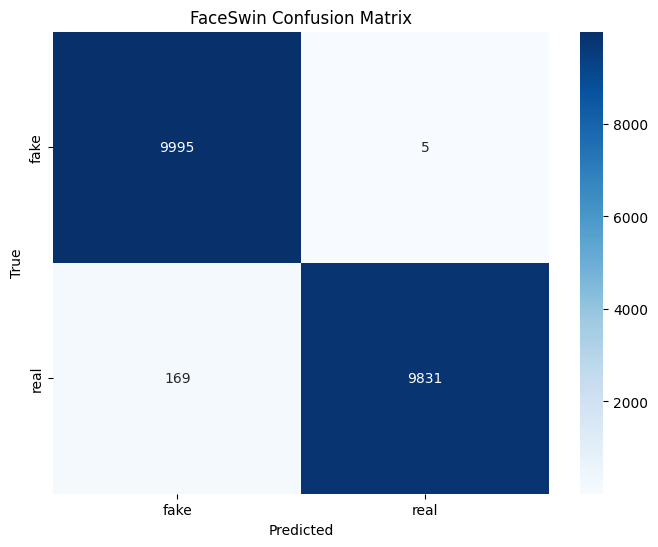

In [19]:
NUM_CLASSES = 2  # Update to match your model
print(Config.device)

# Create model
model = SwinFaceDetector(model_name=Config.model_name, num_classes=2)  # or your exact class
model.load_state_dict(torch.load(Config.checkpoint_path))

model.to(Config.device)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Evaluate model on test set
print("\nEvaluating on test set:")
cm, report, y_true, y_pred = evaluate_model(model, test_dataloader, criterion, Config.device)
print("Classification Report:")
print(report)


In [ ]:

# Inference function
def predict_image(model, image_path, transform, device):
    model.eval()
    
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(image_tensor)
        _, pred = torch.max(output, 1)
    
    result = "Fake" if pred.item() == 0 else "Real"
    prob = torch.softmax(output, dim=1)[0]
    
    return result, prob.cpu().numpy()

# Plotting


Plot saved to /kaggle/working/output/aucroc_plot.png


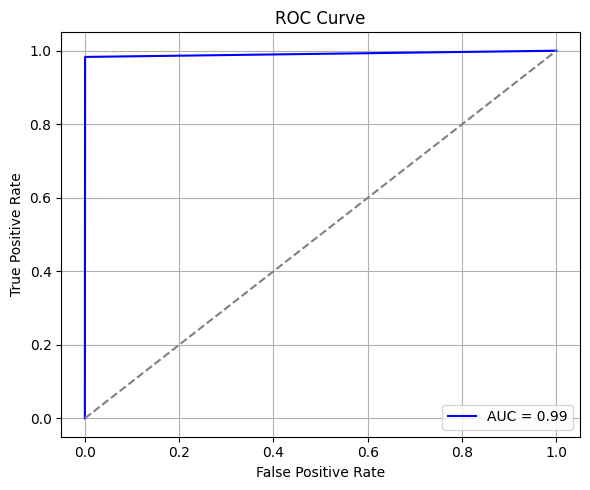

In [20]:
from sklearn.metrics import roc_curve, auc
def plot_auc_roc(y_true, y_pred, save_dir=None):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        plot_path = os.path.join(save_dir, 'aucroc_plot.png')
        plt.savefig(plot_path, dpi = 500)
        print(f"Plot saved to {plot_path}")
    plt.show()

plot_auc_roc(y_true, y_pred, save_dir = "/kaggle/working/output")

In [ ]:
import os
import matplotlib.pyplot as plt

def plot_acc_graphs(df, save_dir=None):
    fig, ax = plt.subplots(figsize=(8, 5))

    ax.plot(df['epoch'], df['train_accuracy'], marker='o', label='Train Accuracy')
    ax.plot(df['epoch'], df['val_accuracy'], marker='o', linestyle='--', label='Validation Accuracy')

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_title('Training vs Validation Accuracy')
    ax.legend()
    ax.set_ylim(bottom=0.0, top=1.0)
    plt.grid(True)
    plt.tight_layout()

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        plot_path = os.path.join(save_dir, 'acc_plot.png')
        plt.savefig(plot_path, dpi=500)
        print(f"Plot saved to {plot_path}")

    plt.show()


def plot_loss_graphs(df, save_dir=None):
    fig, ax = plt.subplots(figsize=(8, 5))

    ax.plot(df['epoch'], df['train_loss'], marker='o', label='Train Loss')
    ax.plot(df['epoch'], df['val_loss'], marker='o', linestyle='--', label='Validation Loss')

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training vs Validation Loss')
    ax.legend()
    ax.set_ylim(bottom=0.0)
    plt.grid(True)
    plt.tight_layout()

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        plot_path = os.path.join(save_dir, 'loss_plot.png')
        plt.savefig(plot_path, dpi=500)
        print(f"Plot saved to {plot_path}")

    plt.show()


In [ ]:
plot_acc_graphs(df, save_dir = "/kaggle/working/output")
plot_loss_graphs(df, save_dir = "/kaggle/working/output")

In [21]:
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, 
    log_loss, brier_score_loss, cohen_kappa_score
)
import numpy as np

def evaluate_metrics(y_true, y_pred_probs, threshold=0.5):
    y_pred_probs = np.array(y_pred_probs)
    y_true = np.array(y_true)

    y_pred = (y_pred_probs >= threshold).astype(int)

    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred),
        'ROC AUC': roc_auc_score(y_true, y_pred_probs),
        'Log Loss': log_loss(y_true, y_pred_probs),
        'Brier Score': brier_score_loss(y_true, y_pred_probs),
        'Cohen\'s Kappa': cohen_kappa_score(y_true, y_pred),
    }

    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

    return metrics

evaluate_metrics(y_true, y_pred, threshold=0.5)

Accuracy: 0.9913
F1 Score: 0.9912
ROC AUC: 0.9913
Log Loss: 0.3136
Brier Score: 0.0087
Cohen's Kappa: 0.9826


{'Accuracy': 0.9913,
 'F1 Score': 0.9912280701754386,
 'ROC AUC': 0.9913,
 'Log Loss': 0.3135797844853194,
 'Brier Score': 0.0087,
 "Cohen's Kappa": 0.9826}

Plot saved to /kaggle/working/output/reliable_plot.png


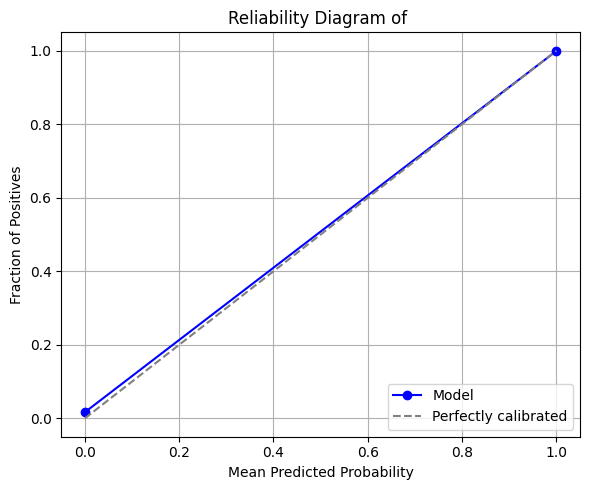

In [23]:
from sklearn.calibration import calibration_curve

def plot_reliability_diagram(y_true, y_pred_probs, n_bins=10, save_dir=None):
    # Compute the calibration curve
    fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_pred_probs, n_bins=n_bins)

    # Plot the reliability diagram
    plt.figure(figsize=(6, 5))
    plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label='Model', color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Reliability Diagram of ')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        plot_path = os.path.join(save_dir, 'reliable_plot.png')
        plt.savefig(plot_path, dpi = 500)
        print(f"Plot saved to {plot_path}")
    plt.show()
plot_reliability_diagram(y_true, y_pred, save_dir = "/kaggle/working/output")

# Grad Cam AND Lime

In [24]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2

def generate_gradcam(model, input_tensor, class_idx=None):
    model.eval()
    model.zero_grad()

    # Forward pass
    output = model(input_tensor)

    # If no class is specified, use the class with highest score
    if class_idx is None:
        class_idx = output.argmax(dim=1).item()

    # Backward pass
    score = output[:, class_idx]
    score.backward(retain_graph=True)

    # Extract gradients and activations
    gradients = model.gradients[0].detach().cpu().numpy()
    activations = model.activations[0].detach().cpu().numpy()

    weights = np.mean(gradients, axis=(1, 2))  # [C]
    cam = np.zeros(activations.shape[1:], dtype=np.float32)  # [H, W]

    for i, w in enumerate(weights):
        cam += w * activations[i]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (input_tensor.shape[3], input_tensor.shape[2]))
    cam -= cam.min()
    cam /= cam.max() + 1e-8

    return cam


In [25]:
def show_and_save_gradcam(img_tensor, cam, save_path=None, alpha=0.5, show=True):
    img = img_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # unnormalize
    img = np.clip(img, 0, 1)

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = heatmap[..., ::-1] / 255.0

    overlay = heatmap * alpha + img * (1 - alpha)
    overlay = np.clip(overlay, 0, 1)

    if show:
        plt.imshow(overlay)
        plt.axis('off')
        plt.title("Grad-CAM")
        plt.show()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        overlay_bgr = (overlay[..., ::-1] * 255).astype(np.uint8)  # RGB to BGR
        cv2.imwrite(save_path, overlay_bgr)


In [26]:
def run_batch_gradcam(model, input_batch, save_dir=None, class_indices=None):
    for i, img_tensor in enumerate(input_batch):
        img_tensor = img_tensor.unsqueeze(0)  # Add batch dim
        class_idx = None if class_indices is None else class_indices[i]

        cam = generate_gradcam(model, img_tensor, class_idx)

        save_path = f"{save_dir}/gradcam_{i}.jpg" if save_dir else None
        show_and_save_gradcam(img_tensor, cam, save_path)


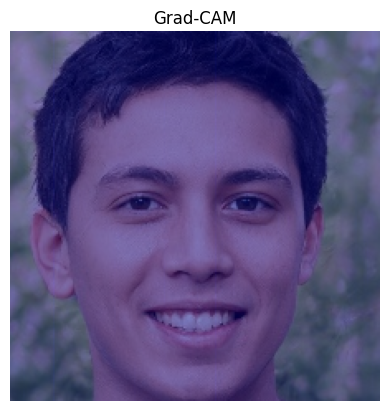

In [35]:
# Get one batch from the validation DataLoader
data_iter = iter(test_dataloader)
images, labels = next(data_iter)

# Pick a single image (e.g., the first one in the batch)
input_tensor = images[3].unsqueeze(0).to(Config.device)  # Add batch dimension

# Run Grad-CAM
cam = generate_gradcam(model, input_tensor)

# Visualize and/or save
show_and_save_gradcam(input_tensor, cam, save_path='outputs/gradcam_3.jpg')

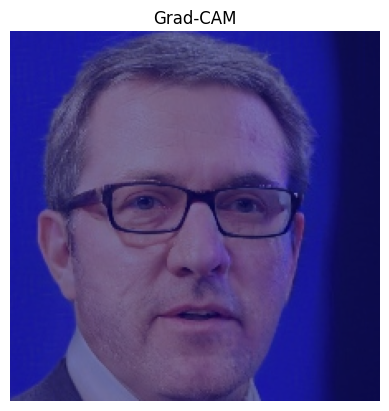

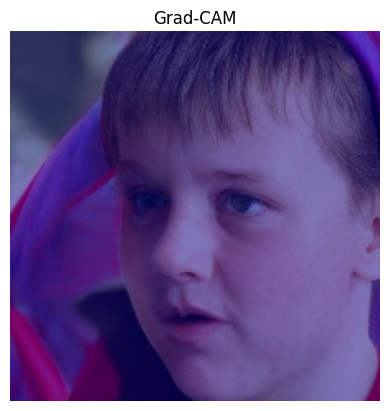

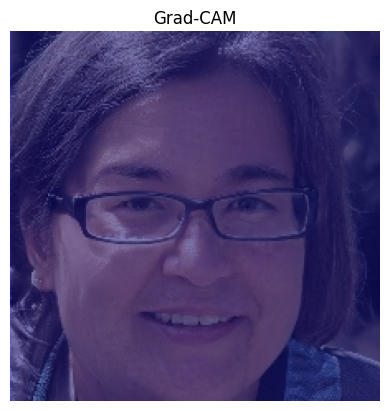

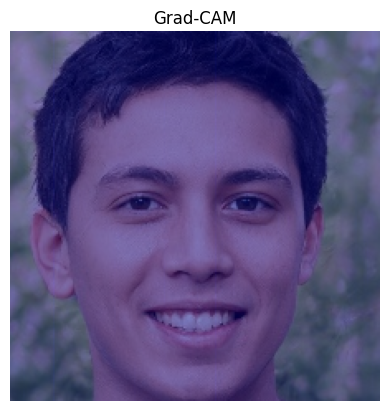

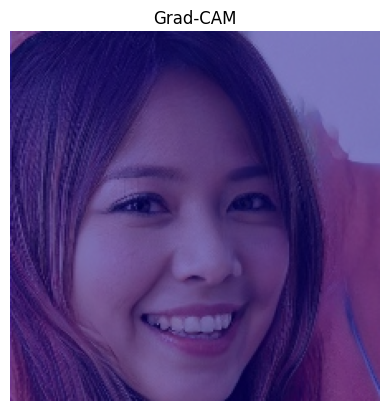

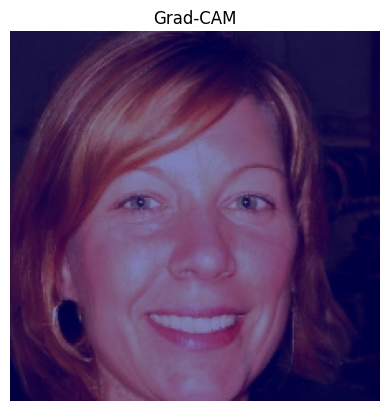

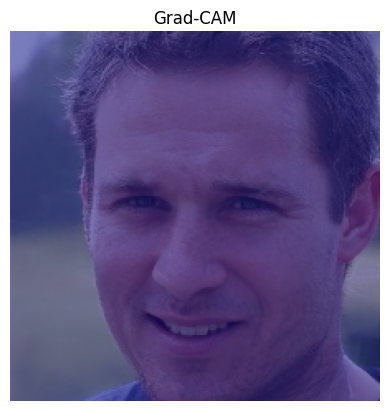

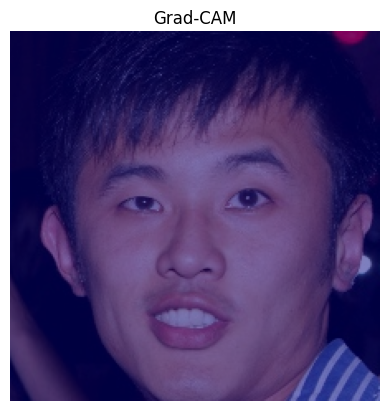

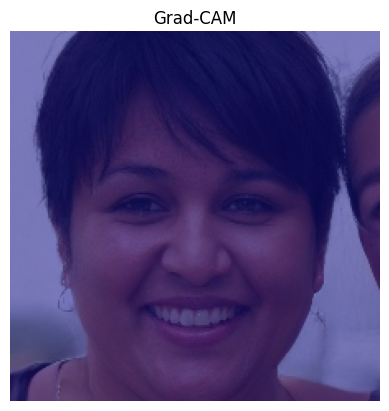

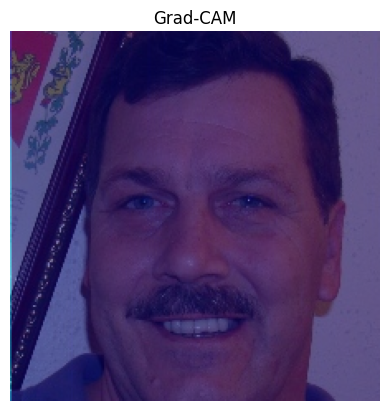

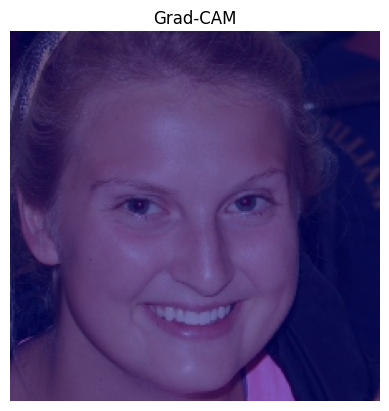

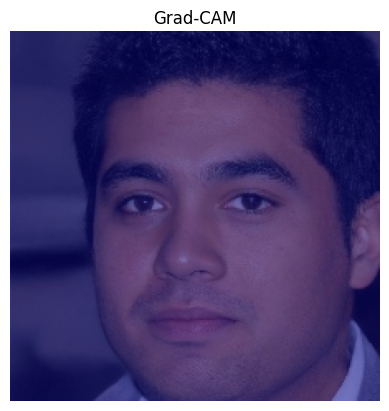

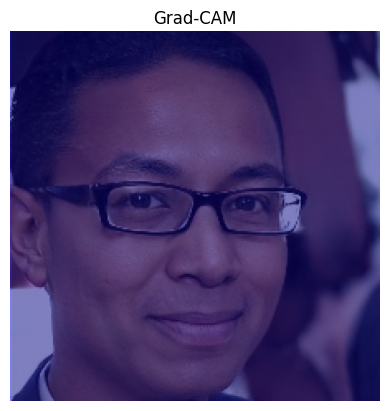

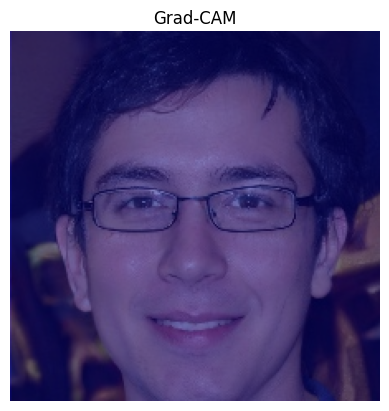

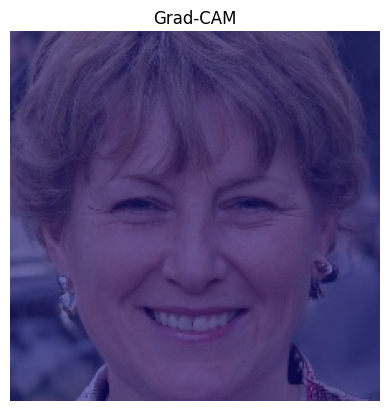

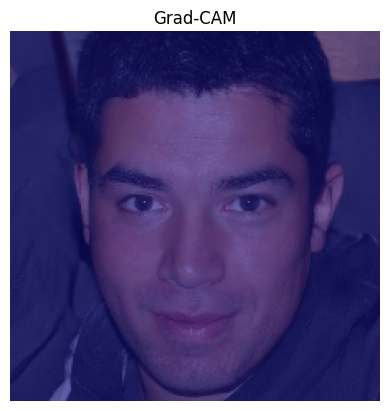

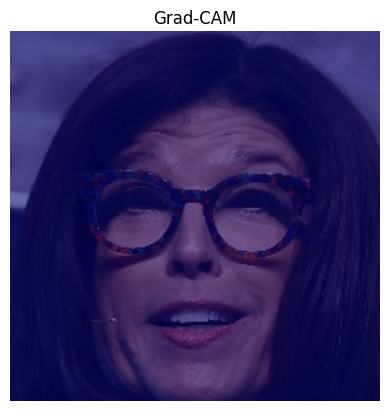

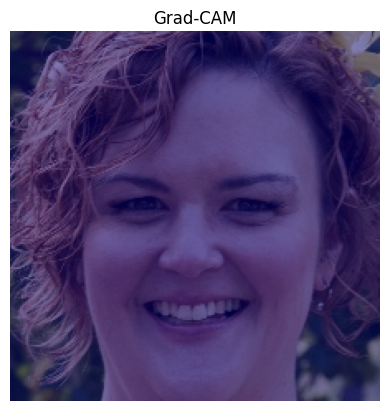

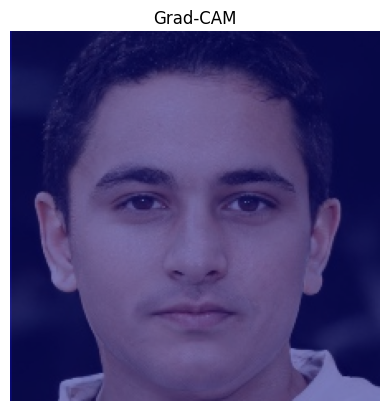

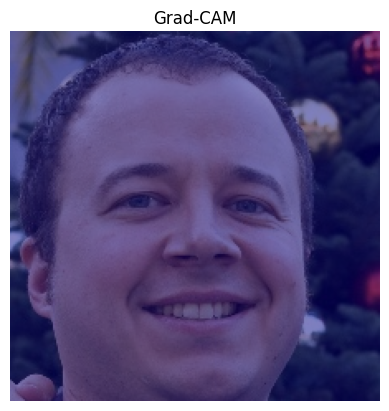

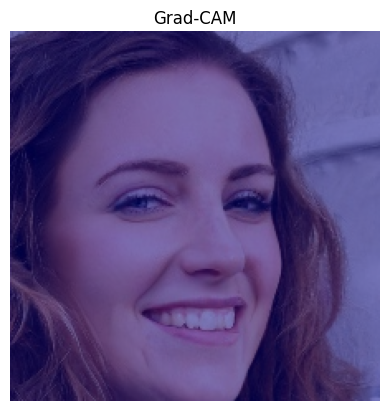

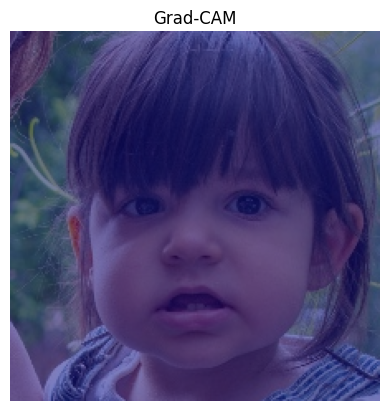

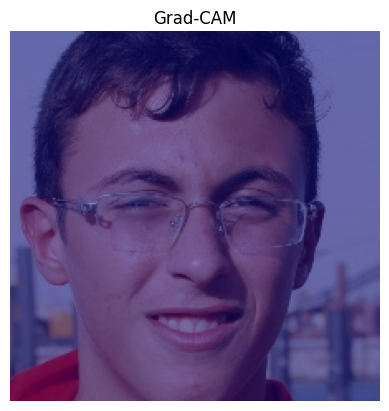

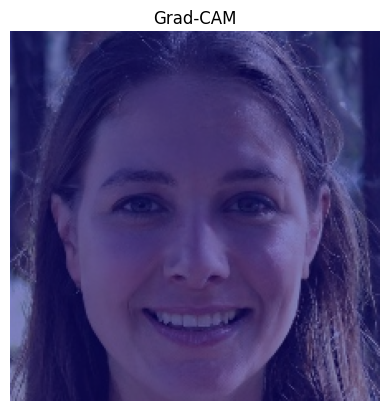

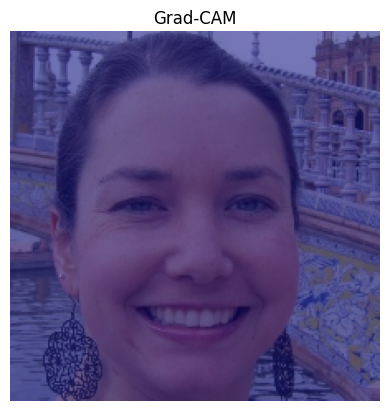

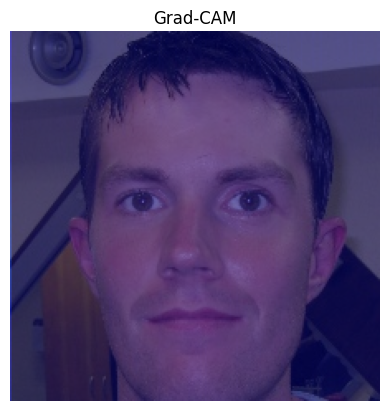

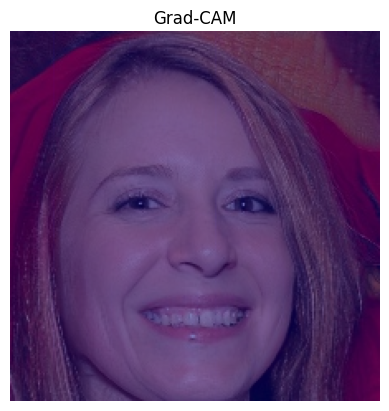

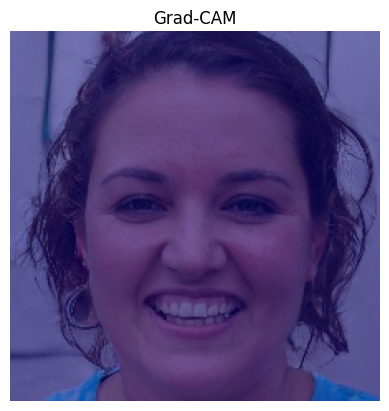

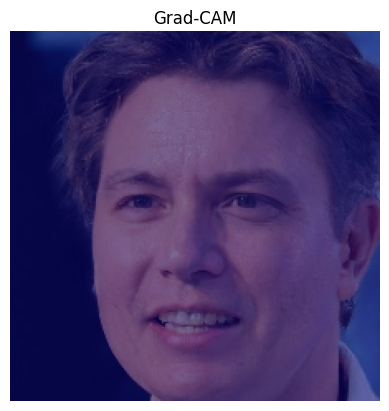

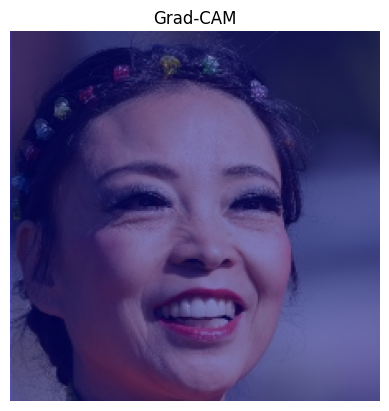

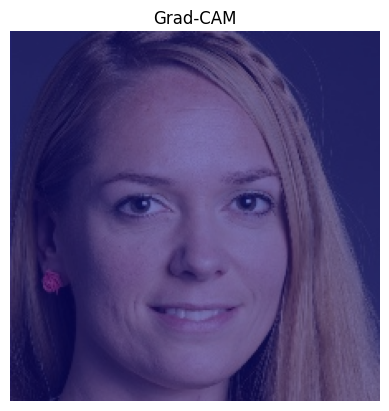

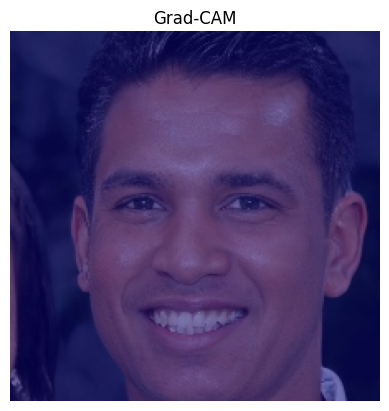

In [37]:
data_iter = iter(test_dataloader)
images, labels = next(data_iter)
# For a batch:
run_batch_gradcam(model, images.to(Config.device), save_dir='outputs/')

In [28]:
# LIME implementation for image explanation
def explain_with_lime(model, image_tensor, transform, num_samples=1000):
    """
    Generate LIME explanation for the model's prediction
    
    Args:
        model: The trained model
        image_tensor: Input image tensor
        transform: The transforms applied to the input image
        num_samples: Number of samples for LIME
    
    Returns:
        Original image and explanation visualization
    """
    model.eval()
    
    # Convert tensor to numpy image
    img = image_tensor[0].permute(1, 2, 0).cpu().numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)
    
    # Define prediction function for LIME
    def predict_fn(images):
        batch = torch.stack([transform(Image.fromarray((image * 255).astype(np.uint8))) 
                            for image in images])
        batch = batch.to(Config.device)
        
        with torch.no_grad():
            preds = model(batch)
            probs = torch.nn.functional.softmax(preds, dim=1)
        
        return probs.cpu().numpy()
    
    # Initialize LIME image explainer
    explainer = lime_image.LimeImageExplainer()
    
    # Get explanation
    explanation = explainer.explain_instance(
        img,
        predict_fn,
        top_labels=2,
        hide_color=0,
        num_samples=num_samples
    )
    
    # Get predicted class
    pred_class = predict_fn(np.array([img]))[0].argmax()
    
    # Get explanation for the predicted class
    temp, mask = explanation.get_image_and_mask(
        pred_class, 
        positive_only=True, 
        num_features=5, 
        hide_rest=False
    )
    
    # Visualization
    explanation_img = mark_boundaries(temp, mask)
    
    return img, explanation_img

In [44]:

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Manually define the transform for Swin using the same ImageNet normalization
        
transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])

# Visualize with Grad-CAM and LIME
print("\nGenerating model explanation visualizations...")

# Get a test image
test_img_path = os.path.join(Config.data_dir, "test", "fake", os.listdir(os.path.join(Config.data_dir, "test", "fake"))[0])
test_img = Image.open(test_img_path).convert('RGB')
test_img_tensor = transform(test_img).unsqueeze(0).to(Config.device)

# Predict class
with torch.no_grad():
    output = model(test_img_tensor)
    _, pred = torch.max(output, 1)
    pred_class = pred.item()
    pred_label = "Fake" if pred_class == 0 else "Real"

print(f"Generating explanations for image predicted as: {pred_label}")

# Generate Grad-CAM visualization
#orig_img, grad_cam_img = generate_gradcam(model, test_img_tensor, target_class=pred_class)
orig_img, heatmap, grad_cam_img  = generate_gradcam(model, test_img_tensor)

# Generate LIME explanation
_, lime_img = explain_with_lime(model, test_img_tensor, val_transform)

# Plot results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(orig_img)
plt.title(f"Original Image\nPredicted: {pred_label}")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(grad_cam_img)
plt.title("Grad-CAM Visualization")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(lime_img)
plt.title("LIME Explanation")
plt.axis('off')

plt.tight_layout()
plt.savefig('model_explanations.png')
plt.show()


Generating model explanation visualizations...
Generating explanations for image predicted as: Fake


ValueError: too many values to unpack (expected 3)